In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, f1_score, roc_curve, auc
from sklearn.ensemble import RandomForestClassifier

%matplotlib inline

# 1

1 (+1). Загрузить titanic.csv. Нарисовать диаграммы (гистограммы/круговые/...), по которым можно будет сравнить 1) вероятность выжить для мужчин и женщин, 2) вероятность выжить для пассажиров разных социально-экономических классов (Pclass), 3) стоимость билета в зависимости от социально-экономического класса. Написать, что вам удалось узнать из этих диаграмм (например, «для пассажира 1 класса вероятность выжить составила XX% и оказалась выше, чем у пассажира 2 класса (YY%)»; чем больше информации вы сможете извлечь из диаграмм, тем лучше)

In [2]:
titan = pd.read_csv('titanic.csv', index_col='PassengerId')

In [3]:
titan.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


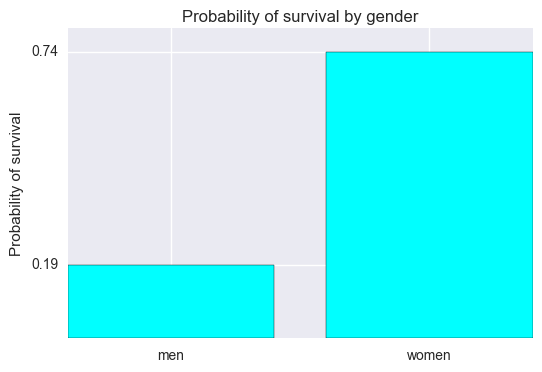

In [4]:
# вероятность выжить для мужчин и женщин
men = titan.loc[titan['Sex'] == 'male']
women = titan.loc[titan['Sex'] == 'female']
men_survived = sum(men['Survived'])
women_survived = sum(women['Survived'])

labels = ('men', 'women')
index = np.arange(len(labels))
numbers = [round(men_survived/len(men), 2), round(women_survived/len(women), 2)]
plt.bar(index, numbers, align='center', color='cyan')
plt.xticks(index, labels)
plt.yticks(numbers)
plt.ylabel('Probability of survival')
plt.title('Probability of survival by gender')
plt.show()

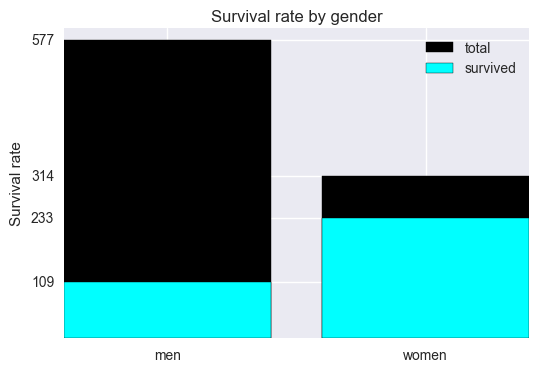

In [5]:
# теперь посмотрим, сколько их там было всего (не там, а в датасете)
N = 2
survived = [men_survived, women_survived]
total = [len(men), len(women)]
ind = np.arange(N)

p1 = plt.bar(ind, total, align='center', color='black')
p2 = plt.bar(ind, survived, align='center', color='cyan')


plt.ylabel('Survival rate')
plt.title('Survival rate by gender')
plt.xticks(ind, labels)
plt.yticks(survived+total)
plt.legend((p1[0], p2[0]), ('total', 'survived'))
plt.show()

Видимо, спасали в первую очередь женщин: для них вероятность выжить оказалась равна 74%, что почти в 4 раза выше, чем у мужчин (19%). Хотя женщин в принципе было меньше почти в два раза, но и абсолютное количество выживших среди них в два раза выше, чем среди мужчин.

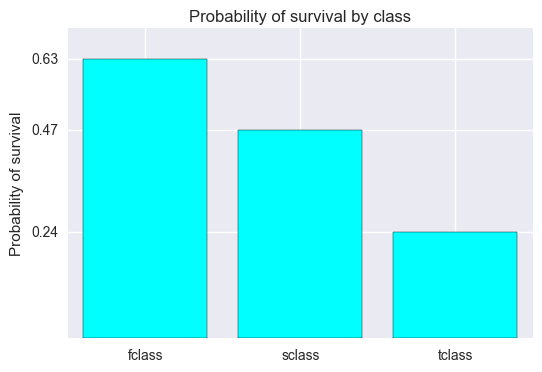

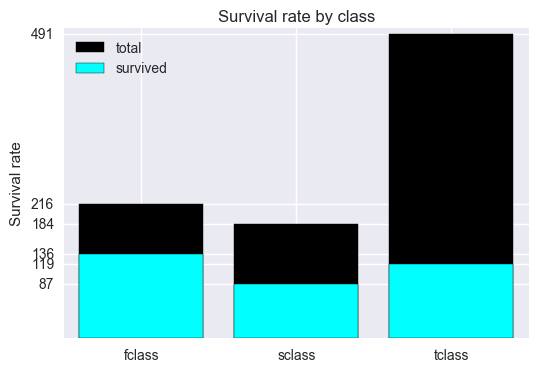

In [6]:
# по классу
labels = ['fclass', 'sclass', 'tclass']
numbers = []
for pclass in labels:
    vars()[pclass] = titan.loc[titan['Pclass'] == labels.index(pclass)+1]
    numbers.append(sum(vars()[pclass]['Survived'])/len(vars()[pclass]))

index = np.arange(len(labels))
numbers = list(map(lambda x: round(x, 2), numbers))
plt.bar(index, numbers, align='center', color='cyan')
plt.xticks(index, labels)
plt.yticks(numbers)
plt.ylabel('Probability of survival')
plt.title('Probability of survival by class')
plt.show()

# ну и количество тоже можно посмотреть
survived = []
total = []
for pclass in labels:
    total.append(len(vars()[pclass]))
    survived.append(sum(vars()[pclass]['Survived']))
index = np.arange(len(total))

p1 = plt.bar(index, total, align='center', color='black')
p2 = plt.bar(index, survived, align='center', color='cyan')

plt.ylabel('Survival rate')
plt.title('Survival rate by class')
plt.xticks(index, labels)
plt.yticks(survived+total)
plt.legend((p1[0], p2[0]), ('total', 'survived'), loc=2)
plt.show()

Итак, видим, что вероятность выжить повышается с увеличением класса: пассажиры первого класса выживали с вероятностью 63%, второго - с вероятностью 47%, а третьего - всего 24%. Однако второй график показывает, что вероятный приоритет более высоких классов при спасении играл не на стороне третьего класса ещё и потому, что третьего класса было очень много(491, что почти в 2,5 раза больше, чем того же первого класса (216)). Тем не менее абсолютное количество спасшихся по классам примерно одинаковое (136 для первого класса, 87 для второго, 119 для первого).

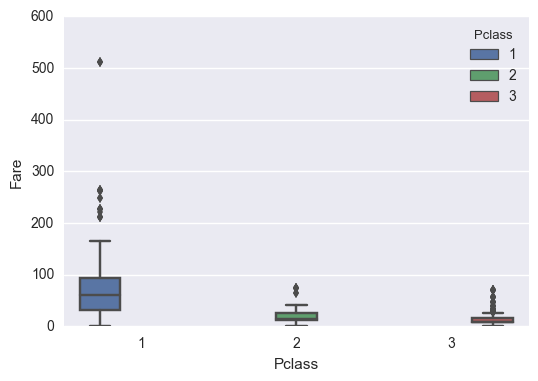

In [7]:
# стоимость билета в зависимости от социально-экономического класса
sns.boxplot(x="Pclass", y="Fare", hue="Pclass", data=titan);

Чем выше класс, тем выше медиана; разброс у второго и третьего класса не очень большой, в пределах 100 долларов со всеми выбросами, и в целом распределения похожи. У первого класса разброс гораздо больше, медиана гораздо выше, а выбросы доходят до сумасшедших значений больше 500 долларов (кто-то купил себе очень дорогую каюту). Даже первый квартиль распределения первого класса находится выше, чем третий квартиль второго класса и всё распределение третьего класса (кроме выбросов).

# 2

2 (+2). А теперь нарисуем два предиктора на одной диаграмме. Нарисовать гистограмму, описывающую среднюю вероятность выжить в зависимости от пола и соц. статуса. Например, это может быть гистограмма с тремя группами столбцов (разделение по соц.статусу), в которой высота столбца соответствует среднему числу выживших, а цвет столбца обозначает пол пассажиров. Снова интерпретировать результаты (Например, какова вероятность выжить женщине из первого класса?). Записать любые два утверждения в виде формул (нужно вспомнить, что такое совместная и/или условная вероятность).

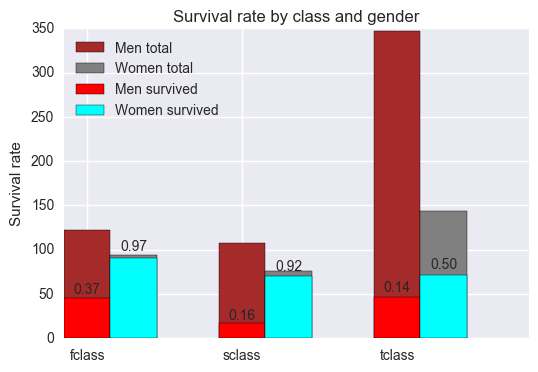

In [8]:
men_class = []
women_class = []
men_class_survived = []
women_class_survived = []
for pclass in labels:
    men_class.append(vars()[pclass].loc[vars()[pclass]['Sex'] == 'male'])
    women_class.append(vars()[pclass].loc[vars()[pclass]['Sex'] == 'female'])
# достанем все нужные числа и превратим 
men_class_survived = list(map(lambda x: sum(x['Survived']), men_class))
women_class_survived = list(map(lambda x: sum(x['Survived']), women_class))
men_class = list(map(len, men_class))
women_class = list(map(len, women_class))

index = np.arange(len(labels))
width = 0.3

fig, ax = plt.subplots()
rects1 = ax.bar(index, men_class, width, color='brown')
rects10 = ax.bar(index, men_class_survived, width, color='r')

rects2 = ax.bar(index + width, women_class, width, color='grey')
rects20 = ax.bar(index + width, women_class_survived, width, color='cyan')

# add some text for labels, title and axes ticks
ax.set_ylabel('Survival rate')
ax.set_title('Survival rate by class and gender')
ax.set_xticks(index + width / 2)
ax.set_xticklabels(labels)

ax.legend((rects1[0], rects2[0], rects10[0], rects20[0]), ('Men total', 'Women total', 'Men survived', 'Women survived'),\
         loc=2)


def problabel(rects, rects_total):
    """
    show the probability above each survived bar
    """
    for i in range(len(rects)):
        height = rects[i].get_height()
        height_total = rects_total[i].get_height()
        ax.text(rects[i].get_x() + rects[i].get_width()/2., 1.05*height,
                '{:.2f}'.format(height/height_total),
                ha='center', va='bottom')

problabel(rects10, rects1)
problabel(rects20, rects2)

Получается, что абсолютное число спасшихся женщин примерно одинаковое по классам, хотя вероятность выжить у женщины из третьего класса в два раза меньше, чем у женщины из первого. В общем у женщины из первого класса самая высокая вероятность выжить - 97%, то есть почти все из этой группы выжили; самая низкая - у мужчины из третьего, что согласуется с предыдущими графиками/выводами. Причём пол более важен: вероятность выжить для женщины из третьего класса на треть больше, чем для мужчины из первого (50% и 37% соответственно).

# 3
3 (+2). Почистите данные так, как считаете нужным (не забывайте про коварную переменную Sex; постарайтесь не удалять строки). Extra: сможете ли вы использовать не 4 столбца, а больше? Например, кажется, что если ребёнок ехал с братом/сестрой, то их не разлучат, а посадят вместе в шлюпку, и они выживут...

In [9]:
# заменим female и male на 0 и 1 соответственно (по алфавиту)
titan['Sex'] = pd.get_dummies(titan['Sex'], drop_first=True).astype(int)

# удалим ненужные столбцы
del titan['Name']
del titan['Ticket']
del titan['Cabin']
del titan['Embarked']

In [10]:
titan.head(6)

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare
PassengerId,,,,,,,
1,0,3,1,22.0,1,0,7.2500
2,1,1,0,38.0,1,0,71.2833
3,1,3,0,26.0,0,0,7.9250
4,1,1,0,35.0,1,0,53.1000
5,0,3,1,35.0,0,0,8.0500
6,0,3,1,NaN,0,0,8.4583


In [11]:
# убираем NaN
for i in titan:
    mu = np.mean(titan[i])
    titan[i] = titan[i].fillna(mu)
titan.head(6)

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare
PassengerId,,,,,,,
1,0,3,1,22.000000,1,0,7.2500
2,1,1,0,38.000000,1,0,71.2833
3,1,3,0,26.000000,0,0,7.9250
4,1,1,0,35.000000,1,0,53.1000
5,0,3,1,35.000000,0,0,8.0500
6,0,3,1,29.699118,0,0,8.4583


# 4
4 (+2). Разделить данные на обучающую и проверочную выборки (или использовать кросс-валидацию). Будем строить дерево решений. Нужно выбрать параметр модели, который, на ваш взгляд, может повлиять на результат, и выбрать для него возможные значения. Прокомментировать свой выбор. Изменяя в цикле значения параметра, посчитать для каждого случая точноть, полноту, F-меру (может быть, другие метрики?). Изобразить результаты на диаграмме/-ах. Интерпретировать результаты. Нарисовать лучшее дерево.

Extra: варьировать не в цикле, а использовать grid search.
Super–duper-Extra: построить ROC-кривую и написать свою интерпретацию того, что эта диаграмма говорит о модели.

In [12]:
y = titan['Survived']
del titan['Survived']

In [21]:
X_train, X_test, y_train, y_test = train_test_split(titan, y)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)
X_test.describe()

(668, 6) (223, 6) (668,) (223,)


,Pclass,Sex,Age,SibSp,Parch,Fare
count,223.000000,223.000000,223.000000,223.000000,223.000000,223.000000
mean,2.282511,0.632287,29.228925,0.461883,0.300448,37.234061
std,0.825281,0.483267,12.897160,1.042835,0.680719,66.678233
min,1.000000,0.000000,0.670000,0.000000,0.000000,0.000000
25%,2.000000,0.000000,22.000000,0.000000,0.000000,7.925000
50%,3.000000,1.000000,29.699118,0.000000,0.000000,13.000000
75%,3.000000,1.000000,33.000000,1.000000,0.000000,27.810400
max,3.000000,1.000000,70.000000,8.000000,4.000000,512.329200


In [22]:
tr = DecisionTreeClassifier(random_state=7)

Из параметров настройки выбрала минимальное количество (сэмплов?) в листе и максимальную глубину, т.к. кажется, что и то, и другое работает против переобучения

In [31]:
parameters = {'min_samples_leaf': list(range(1, 11, 2)), 'max_depth': [None, 3, 5, 7]}
clf = GridSearchCV(tr, parameters)
clf.fit(X_train, y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=7, splitter='best'),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'max_depth': [None, 3, 5, 7], 'min_samples_leaf': [1, 3, 5, 7, 9]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [32]:
print(clf.best_score_)
print("Best parameters set:")
best_parameters = clf.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
    print("\t{}: {}".format(param_name, best_parameters[param_name]))

0.794910179641
Best parameters set:
	max_depth: 7
	min_samples_leaf: 5


In [68]:
y_true, y_pred = y_test, clf.predict(X_test)
print(classification_report(y_true, y_pred))

             precision    recall  f1-score   support

          0       0.87      0.90      0.89       135
          1       0.84      0.80      0.82        88

avg / total       0.86      0.86      0.86       223



In [26]:
# baseline
tr.fit(X_train, y_train)
y_tr_tr, y_pr_tr = y_test, tr.predict(X_test)
print(classification_report(y_tr_tr, y_pr_tr))

             precision    recall  f1-score   support

          0       0.82      0.86      0.84       135
          1       0.77      0.72      0.74        88

avg / total       0.80      0.80      0.80       223



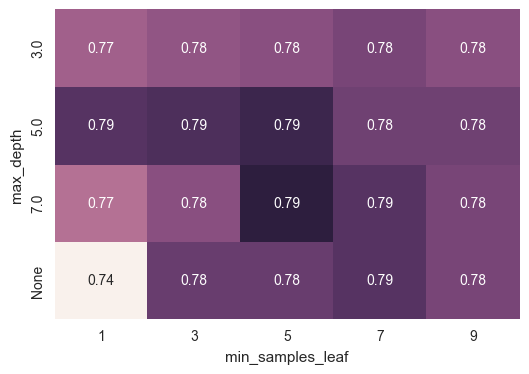

In [72]:
# Изобразить результаты на диаграмме/-ах.
means = clf.cv_results_['mean_test_score']
data = []
for mean, params in zip(means, clf.cv_results_['params']):
    data.append([mean, params['max_depth'], params['min_samples_leaf']])

data = pd.DataFrame(data, columns=['mean']+list(parameters.keys())).fillna("None")
data = data.pivot('max_depth', 'min_samples_leaf', 'mean')
sns.heatmap(data, annot=True, cbar=False);

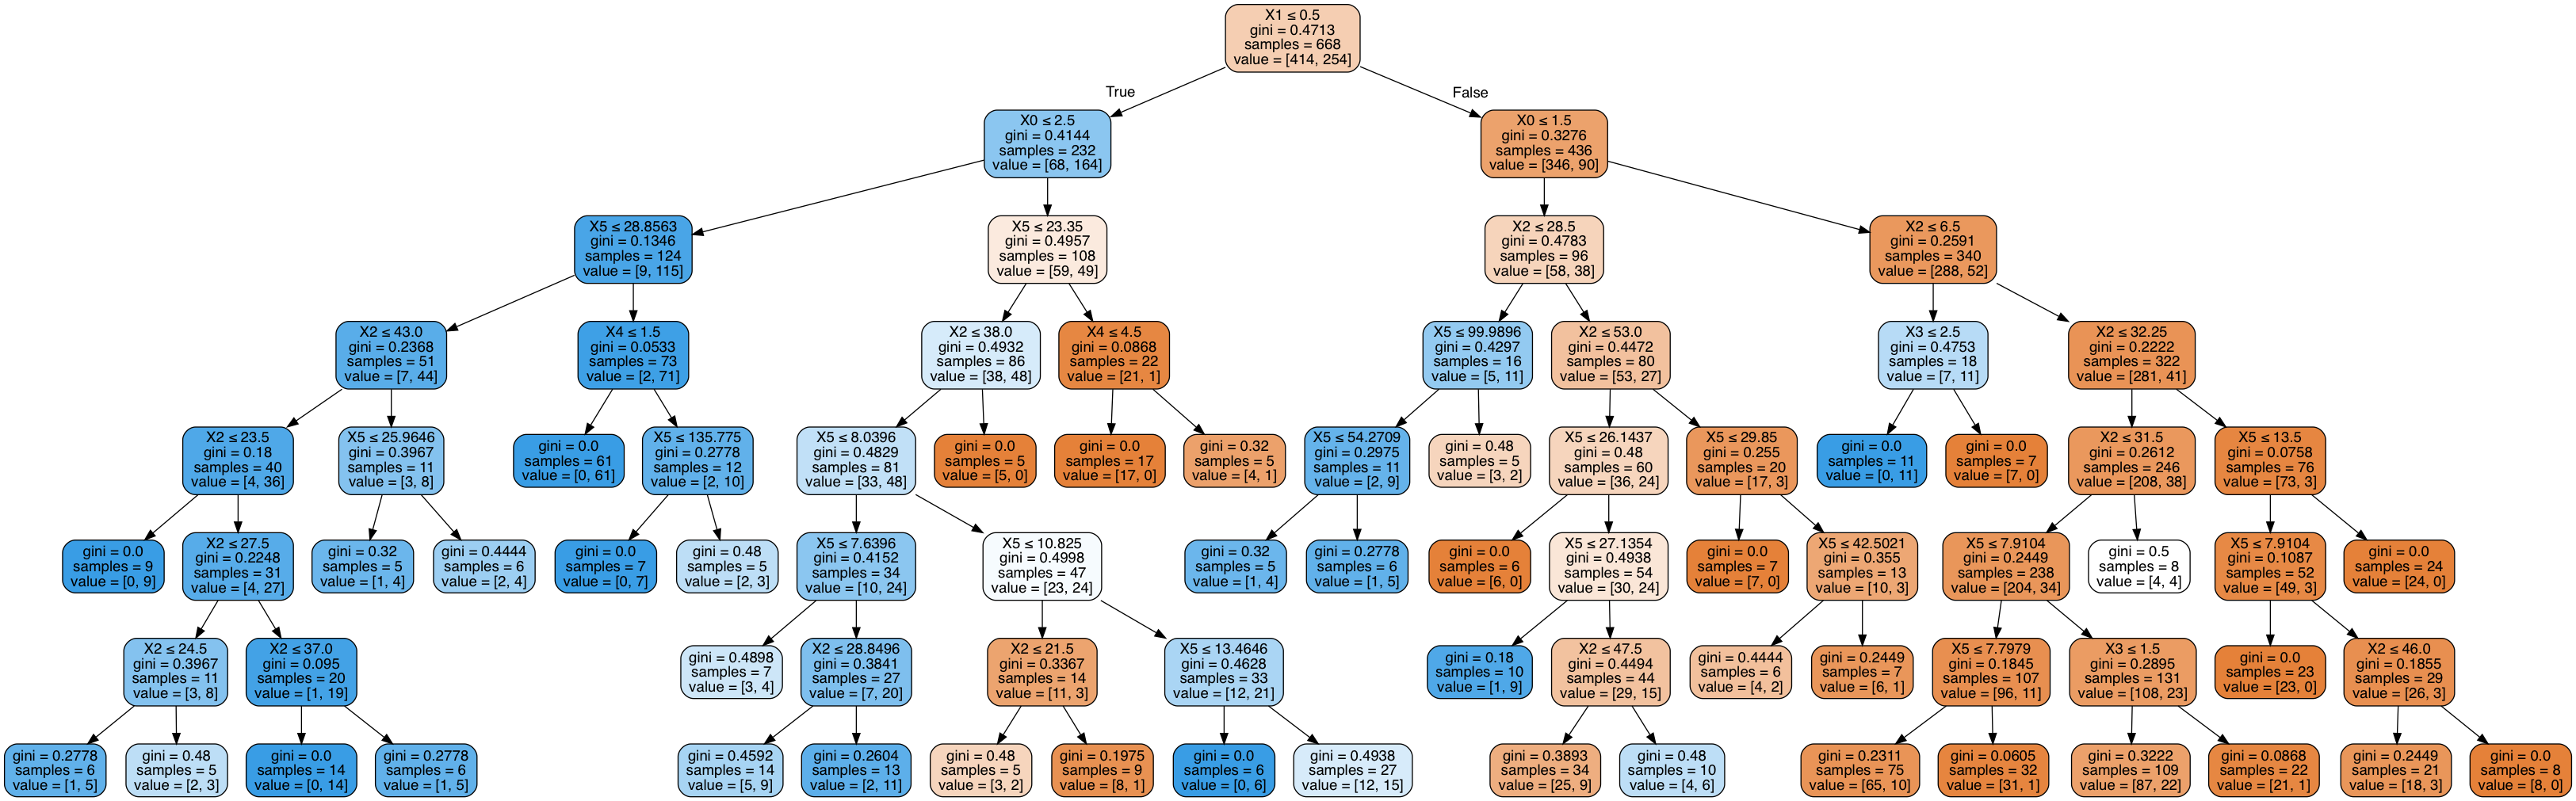

In [35]:
from sklearn.tree import export_graphviz
from IPython.display import Image
import pydotplus
dot_data = export_graphviz(clf.best_estimator_, out_file=None, filled=True, rounded=True, special_characters=True)  
graph = pydotplus.graph_from_dot_data(dot_data)  
Image(graph.create_png())

Наилучшая модель действительно оказалась с недефолтными характеристиками, хотя подкручиванием удалось выиграть только 6%; подкручивание даёт больший буст выжившим (8% против 4-5% к невыжившим). Более того, дефолтная модель оказалась самой худшей (не сказать, чтобы большой отрыв, но тем не менее). В целом модель лучше работает на невыживших, что и понятно, потому что их больше. 

Super–duper-Extra: построить ROC-кривую и написать свою интерпретацию того, что эта диаграмма говорит о модели.

# 5

5 (+2). Проделать аналогичные операции для модели Random Forest. Сравнить результаты.

In [ ]:
model = RandomForestClassifier(n_estimators = 100)

In [ ]:
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

In [ ]:
scores = []
for t in range(1,100):
    rfc = RandomForestClassifier(n_estimators=t)
    rfc.fit(X_train, y_train)
    y_pred = rfc.predict(X_test)
    scores.append(f1_score(y_test, y_pred))


In [ ]:
plt.plot(scores)
plt.xlabel('n_estimators')
plt.ylabel('score')
plt.show()

# # сравнить результаты надо хаха